## Planet: Understanding the Amazon from Space

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
ls {PATH}

__MACOSX/  test-jpg/             test_v2_file_mapping.csv  train-jpg/
models/    test-jpg-additional/  tmp/                      train_v2.csv


In [14]:
glob(f'{PATH}test-jpg/*.jpg')

['data/planet/test-jpg/test_25202.jpg',
 'data/planet/test-jpg/test_5717.jpg',
 'data/planet/test-jpg/test_40598.jpg',
 'data/planet/test-jpg/test_35442.jpg',
 'data/planet/test-jpg/test_22859.jpg',
 'data/planet/test-jpg/test_13670.jpg',
 'data/planet/test-jpg/test_3503.jpg',
 'data/planet/test-jpg/test_34533.jpg',
 'data/planet/test-jpg/test_22003.jpg',
 'data/planet/test-jpg/test_18026.jpg',
 'data/planet/test-jpg/test_10689.jpg',
 'data/planet/test-jpg/test_3334.jpg',
 'data/planet/test-jpg/test_20458.jpg',
 'data/planet/test-jpg/test_28271.jpg',
 'data/planet/test-jpg/test_37800.jpg',
 'data/planet/test-jpg/test_21093.jpg',
 'data/planet/test-jpg/test_38857.jpg',
 'data/planet/test-jpg/test_40095.jpg',
 'data/planet/test-jpg/test_29567.jpg',
 'data/planet/test-jpg/test_15236.jpg',
 'data/planet/test-jpg/test_19257.jpg',
 'data/planet/test-jpg/test_36741.jpg',
 'data/planet/test-jpg/test_16020.jpg',
 'data/planet/test-jpg/test_39014.jpg',
 'data/planet/test-jpg/test_29186.jpg',
 'd

In [17]:
def get_path(folder): return glob(f'{PATH}{folder}-jpg/*.jpg')[0]

In [20]:
# lista con una foto de cada folder
[get_path('train'), get_path('test')]

['data/planet/train-jpg/train_23452.jpg',
 'data/planet/test-jpg/test_25202.jpg']

In [21]:
list_paths = [get_path('train'), get_path('test')]

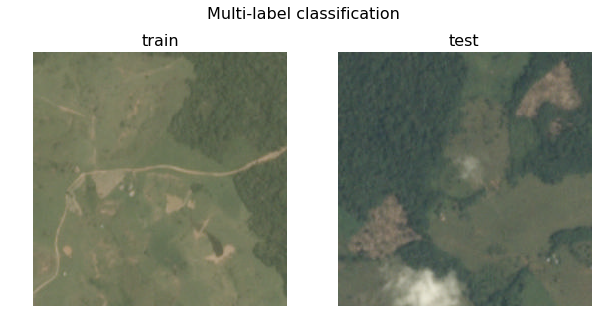

In [23]:
from fastai.plots import *
plots_from_files(list_paths, titles=["train", "test"], maintitle="Multi-label classification")

In [29]:
??plots_from_files

In [49]:
def get_path(folder,num) : return glob(f'{PATH}{folder}-jpg/*.jpg')[:num] 
list_paths = [get_path("train",2)]


In [50]:
list_paths

[['data/planet/train-jpg/train_23452.jpg',
  'data/planet/train-jpg/train_14536.jpg']]

In [52]:
plots_from_files = (list_paths)

## Multi-label versus single-label classification

In [5]:
from fastai.plots import *

In [54]:
# llega un path, obtiene todos los ficheros en ese path con el patron que hay en glob, recupera el primero
def get_1st(path): return glob(f'{path}/*.*')[0]

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

"por tanto no podemos usar softmax, softmax wants to pick a single thing, elige una clase en concreto. Aqui cada ejemplo\ncan belong to one or more classes\n\nEn fastai no tenemos que cambiar nada, si ve que hay mas de un label en el csv de las labels, cambia automaticamente a 'multilabel mode'\n"

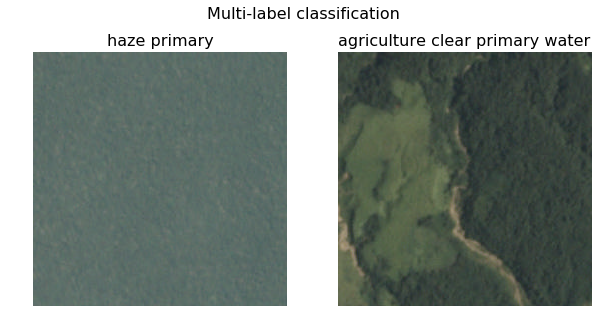

In [35]:
# una lista con tantas rutas como fotos queramos visualizar
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")


Kaggle evaluara esta competicion con la metrica f2 (es una forma de sopesar los falsos positivos y falsos negativos de la confussion matrix)

In [5]:
from planet import f2
# podemos crear nuestras propias metrics siempre que reciban 2 numpy arrays y devuelvan un numero. Luego la meteriamos en el argumento metrics al crear el objeto learn
metrics=[f2]
f_model = resnet34

In [6]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1 # n es la cantidad total de archivos de label_csv
val_idxs = get_cv_idxs(n) # sacamos un 20% de los indices para validation

Creamos nuestro objeto data con data augmentation ... por qué? porque queremos permitir giros verticales en las fotos de entrenamiento. Permitir giros horizontales no tendria mucho sentido pues entrenamos con fotos del mismo estilo que las del test set, y todas son fotos tomadas desde arriba

In [9]:
def get_data(sz):
    # usamos aug_tfms (data augmentation)
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg') 

In [ ]:
# con iter obtenemos un iterador sobre el batch data.val_dl. Teniendo el iterador, next nos devuelve el siguiente minibatch
# osea: x tiene las images del minibatch, 'y' tiene las labels del minibatch 
x,y = next(iter(data.val_dl))

In [43]:
# zip empareja cada clase de data.classes con cada label de 'y' y asi sabemos que clases corresponden a los 1s de 'y'
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

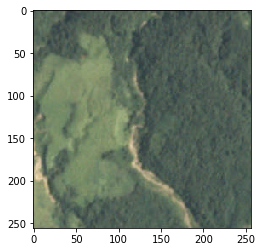

In [44]:
# sacamos la primera imagen del validation dataset y la hacemos mas clara (multiplicamos cada numero de la matriz por 1.4)
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

Esta competicion usa imagenes nada parecidas a Image Net. Como las imagenes que usamos aqui no tienen nada que ver con las que se usaron para entrenar la arquitectura, entonces tendremos que entrenar toda la red presumiblemente. Le bajamos el tamaño a las imagenes para que este re entrenamiento no sea muy duradero

In [13]:
# resize from 256 to 64
sz=64

In [14]:
data = get_data(sz)

In [15]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.21489    0.323594   0.801732  



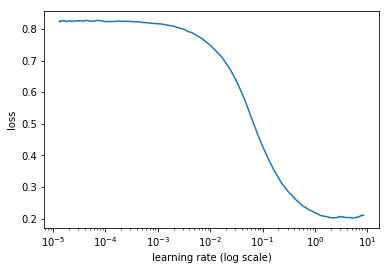

In [16]:
# ejecutamos un epoch para saber como cambia la loss a medida que aumentamos learning rate en cada batch 
lrf=learn.lr_find()
# ya podemos mostrar la relacion loss vs learning rate
learn.sched.plot()

Vemos que la learning rate que se corresponde con la máxima pendiente de la funcion loss. No elegimos un valor mayor porque sería demasiado grande, tan grande que es posible que la pérdida empezase a aumentar al poco de entrenar por estar pasando por encima de los minimos sin converger. No elegimos un valor menor porque el entrenamiento seria muy largo (la actualizacion de los pesos seria muy pequeña cada vez)

In [16]:
lr = 0.2

Hemos dicho que nuestro training data es muy diferente a ImageNet (la arquitectura en la que se entrenó nuestro modelo resnet-34) y por eso debíamos entrenar toda la red en algun momento. Pero tambien es cierto que el aprendizaje obtenido en las primeras capas de resnet-34 si que nos puede valer, porque esas primeras capas aprenden conceptos geometricos muy basicos como angulos y lineas rectas que nos pueden ser utiles. Asi que la estrategia es primero entrenar la capa que hemos añadido nosotros (fast ai la añade por defecto capas del tipo 'fully conected' en función de las clases que queramos clasificar) y despues entrenar toda la red, quizás con distintas learning rates (nos interesa que las primeras capas se actualicen muy despacio porque tienen un conocimiento aprendido que nos es util, las capas intermedias tienen que actualizarse mas deprisa, y las capas finales aun más deprisa para que aprendan conceptos de nuestro propio training set)

In [50]:
# al poner el argumento cycle_mult, fastai implementa un entrenamiento con un esquema de learning rate ciclica. Mirad en mi
# repositorio porque hay o habrá un documento explicando dicho paper
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.144752   0.132914   0.883516  
    1      0.140223   0.12819    0.886356                    
    2      0.136196   0.124797   0.890896                    
    3      0.136899   0.124366   0.891919                    
    4      0.132194   0.1221     0.894989                    
    5      0.130741   0.120824   0.895143                    
    6      0.127375   0.120367   0.895706                    



[0.12036674, 0.8957060053598156]

In [51]:
learn.save("34_{sz}_antesdeunfreeze")

Ahora procedemos a entrenar toda la red:
    - usamos distintas learning rates para distintas capas de la red
    - hacemos 'unfreeze' para descongelar toda la red y poder entrenar todas las capas

Ya dijimos que en imagenes parecidas a imagenet, usabamos un factor entre una learning rate y otra de 10 (la mas pequeña es la mas cercana a las imagenes, porque ya ha aprendido cosas que nos valen mucho, las mas grandes estan en la parte mas profunda de la red, para que aprendan cosas muy complejas del problema que queremos en concreto). En este caso, las imagenes no se parecen en nada a ImageNet, asi que usamos un factor de 3 entre las learning rates.

Asi pues, preparamos 3 learning rates distintas, la mas a la izquierda para las primeras capas

In [56]:
lrs = np.array([lr/9,lr/3,lr])

In [57]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.11898    0.106585   0.910426  
    1      0.112011   0.100732   0.916259                    
    2      0.10309    0.098546   0.916654                    
    3      0.10898    0.10076    0.914097                    
    4      0.102223   0.097084   0.917059                    
    5      0.094953   0.094872   0.919424                     
    6      0.094266   0.093309   0.921974                     



[0.09330905, 0.9219737239633837]

In [58]:
learn.save("34_{sz}_unfreeze")

Dijimos que el entranmiento emplea un esquema de learning rate ciclico. Basicamente empieza utilizando la learning rate que le hemos dado (en unas capas la learning rate inicial es una, en otras es otra, pero en todas las capas se sigue el mismo esquema) y la va disminuyendo siguiendo un esquema coseno a medida que procesa cada batch de datos. Cuando ha acabado de procesar todos los batch, inicializa otro ciclo empezando con el valor inicial de la learning rate en esa capa y volviendo a disminuir, quizas mas lentamente, hasta volver a procesar todos los batchs de datos. Estos ciclos los repite 3 veces

Si nos fijamos, ahora learn.sched (la planificacion del objeto learn) es un objeto de tipo sgdr.cosAnneal (stochastic gradient descent with restarts). Escribiré sobre el paper al que hace referencia para entenderlo mejor 

In [60]:
learn.sched

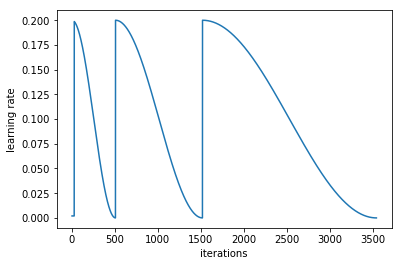

In [23]:
# por tanto la learning rate tiene un esquema (sched) cosine annealing. Lo podemos comprobar asi
learn.sched.plot_lr() 

Y por que ir cambiando tanto el valor de la learning rate? Cuando al final de cada ciclo la learning rate vuelve a adquirir el valor inicial (más grande) esto lleva a que la funcion de perdida se dispare y salga del minimo local en la que estaba (al aumentar tanto la learning rate, los parametros de la red se actualizan a valores muy distintos de golpe, pasando a otro punto alejado de la funcion de perdida, presumiblemente fuera del minimo donde estabamos). Esto tiene sentido hacerlo porque no todos los minimos nos interesan: nos interesan aquellos minimos planos tales que, una variacion pequeña de los parametros no nos saque del minimo. Estos minimos parecen ser mejor para la generalizacion de la red. Asi que durante el entrenamiento, vamos 'dando saltos' (aumentando la learning rate de golpe con el inicio de un nuevo ciclo). Si el salto nos saca del minimo donde estabamos, entonces era muy estrecho y no nos interesaba, si no nos saca porque estabamos en un buen minimo, entonces el salto no vale para nada y el siguiente ciclo nos iremos acercando aun mas a ese minimo del que no hemos salido

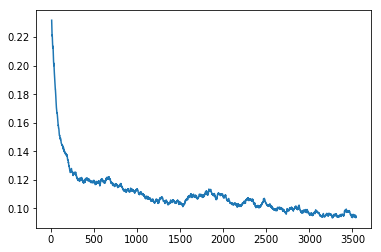

In [61]:
# cómo cambia la loss (eje Y) respecto de las sucesivas iteraciones (batchs, eje X). 
learn.sched.plot_loss()

Como se puede comprobar, se aprecian los ciclos cada nuevo ciclo la learning rate sube y por tanto la perdida aumenta de golpe

A partir por aqui: 
    - aumentar imagenes (para prevenir overfitting)
    - congelar
    - entrenar solo la ultima capa
    - descongelar, entrenar toda la red
    - guardar. 

Notad que mientras la red esta congelada (y por tanto solo entrenamos la fully conected layer del final que añadimos nosotros) usamos learn.fit(lr ... ) y cuando descongelamos la red y por tanto vamos a entrenar todas las capas, usamos learn.fit(lrs ...) (el array de learning rates distintas)

Esto lo hacemos un par de veces

In [63]:
sz=128

In [64]:
learn.set_data(get_data(sz))
learn.freeze()
# aqui estamos con precompute=True (no lo pusimos a false explicitamente, se puso porque usamos unfreeze y aqui lo estamos congelando otra vez)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.09835    0.093924   0.919917  
    1      0.093959   0.092755   0.921146                     
    2      0.096303   0.092695   0.92071                      
    3      0.095513   0.092706   0.920687                     
    4      0.094353   0.092243   0.92064                      
    5      0.095053   0.092295   0.920826                     
    6      0.090901   0.091589   0.921471                     



[0.09158856, 0.9214708524607597]

In [65]:
learn.unfreeze() # pone precompute=False para que vayan recalculandose las activaciones en sucesivos batchs conforme se cambian los pesos
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f"34_{sz}_unfreeze")

epoch      trn_loss   val_loss   f2                           
    0      0.094808   0.088975   0.925228  
    1      0.090684   0.088009   0.926227                     
    2      0.086484   0.08579    0.9277                       
    3      0.091726   0.091194   0.920615                     
    4      0.087239   0.087149   0.92573                      
    5      0.083286   0.085372   0.92878                      
    6      0.083744   0.084851   0.928679                     



In [9]:
# cargamos el modelo. Precompute=False, sz=128, arch = resnet34
arch = resnet34
sz = 128
data = get_data(sz)
metrics = [f2]
learn = ConvLearner.pretrained(arch, data, metrics=metrics) # precompute=False by default
lr = 0.2
lrs = np.array([lr/9,lr/3,lr])

In [10]:
# ya tenemos creada la isntancia learn, ahora cargamos el modelo 
learn.load(f"34_{sz}_unfreeze")

In [19]:

sz=256

In [20]:
learn.set_data(get_data(sz))
learn.freeze()
# este entrenamiento esta siendo muy largo a pesar de estar solo entrenando la ultima capa...es por el tamaño de la foto
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.08887    0.089188   0.924491  
    1      0.089131   0.088157   0.925967                     
    2      0.089106   0.087819   0.925997                     
    3      0.089353   0.087986   0.926406                     
    4      0.086343   0.087618   0.926058                     
    5      0.089554   0.087029   0.927033                     
    6      0.091396   0.08727    0.926393                     



[0.08726984, 0.9263929660996509]

In [21]:
learn.save(f"34_{sz}_freeze")

In [22]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f"34_{sz}_unfreeze")

epoch      trn_loss   val_loss   f2                           
    0      0.086601   0.083861   0.931113  
    1      0.087129   0.083681   0.930509                     
    2      0.083055   0.082123   0.931459                     
    3      0.088838   0.084683   0.929637                     
    4      0.083262   0.083566   0.931144                     
    5      0.080473   0.081773   0.932468                     
    6      0.078569   0.081394   0.932574                     



In [17]:
# cargamos el modelo ya entrenado
arch = resnet34
sz = 256
data = get_data(sz)
metrics = [f2]
learn = ConvLearner.pretrained(arch, data, metrics=metrics) # precompute=False by default
lr = 0.2
lrs = np.array([lr/9,lr/3,lr])
learn.load(f"34_{sz}_unfreeze")

In [18]:
# dentro del validation set, comparamos (o calculamos la metrica f2 sobre) predicciones y las targets del validation set
probs = learn.predict()
f2_no_TTA = f2(probs, data.val_y)

probsTTA,y = learn.TTA()
probsTTA = np.mean(probsTTA, axis=0)
f2_TTA = f2(probsTTA, y)



In [20]:
print(f'f2 sin TTA: {f2_no_TTA}, f2 con TTA : {f2_TTA}')

f2 sin TTA: 0.9289114651075988, f2 con TTA : 0.9309460632413215


Sin ningun tipo de ensambling, se consigue una posicion de 106 de 938

<img src="score_planet.png">

En otra ocasión, probaré distintos metodos de ensambling que estoy estudiando ultimamente. Se que hay quien simplemente ha entrenado 5 redes de la misma arquitectura que la que se muestra aqui y al final ha promediado sus predicciones, y sobre éstas predicciones promedio, ha calculado la métrica f2, lo que le ha llevado a la posición treinta y pico del public leaderbord.

Eso lo dejaré para más adelante, aunque el método seria algo así como:
    - entrenar 5 redes neuronales como la que se presenta aquí, quizás durante menos epochs y con transformaciones distintas a la hora de crear el objeto data, porque cada una alcanzará minimos distintos y el promedio sera una red en un minimo algo mas plano y por tanto que generaliza mejor sobre el test set
    - una vez construidas, promediar sus predicciones 
    

De todas formas me gustaría probar otras formas de ensembling que no pasen por entrenar redes neuronales distintas. Eso es una pérdida tiempo, piensa que la misma red neuronal es capaz de llegar a distintos minimos cuando hace los 'restarts' sobre su tasa de aprendizaje. Lo suyo seria guardar pesos cada vez que llegue a esos minimos, y promediarlos despues. Asi, entrenando una sola red, podriamos tener 4 o 5 configuraciones de pesos distintas que llevan a minimos distintos ... (es solo una idea)

Solo resta subirlo a Kaggle. Primero le echamos un ojo a lo que tenemos. Por ejemplo, vamos a ver cuales son nuestras predicciones para la primera foto del test, y cual es el formato de predicciones para la primera foto que nos dan

In [22]:
# lo que nosotros hemos obtenido
print(probsTTA[0]) # usamos las predicciones obtenidas por votacion tras el tta
# las predicciones tipo que tenemos en el predictions sample
y[0]

[0.70557 0.0013  0.01651 0.00061 0.00071 0.9998  0.00005 0.00029 0.26843 0.01833 0.00029 0.00005 0.99968
 0.18405 0.00227 0.0095  0.86515]


array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)

Es decir, por cada foto tenemos 17 numeros reales (probabilidad de que esa foto pertenezca a cada una de las 17 clases), y lo que deberiamos tener es si pertenece o no a dicha clase (0s o 1s). Por tanto, hay que elegir un threshold (valor umbral) por encima del cual nuestra prediccion pasa a ser 1 y por debajo del cual es 0. Asi podriamos saber, dadas nuestras 17 predicciones para la primera foto, cuales considerariamos posibles clasificaciones para esa foto (una foto puede tener varios labels)

Utilizamos una funcion opt_th de la libreria de fastai. Esta funcion prueba distintos valores (para cada valor umbral, se obtiene un grupo de predicciones distintas en funcion de si pasan dicho valor umbral o no) y calcula sobre las predicciones resultantes la metrica f2; la funcion se queda con el valor umbral que mayor f2 devuelve

In [24]:
from planet import opt_th

In [25]:
threshold = opt_th(probs, y)
print(threshold)

0.22000000000000006


In [ ]:
test_preds, _ = learn.TTA(is_test=True) # 5 predicciones por foto (cada foto en lugar de tener 17 numeros reales, tiene 17 x 5 )
preds = np.mean(test_preds, axis=0) # ahora cada foto tiene su prediccion (sus 17 numeros para las 17 posibles clases)

classes = np.array(data.classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))]) for pp in preds])

Ahora creamos el data frame para poder subirlo

In [31]:
import os, sys
sys.path.append('../')

filenames = np.array([os.path.basename(fn).split('.')[0] for fn in data.test_ds.fnames])
frame=pd.DataFrame(res, index=filenames, columns=['tags'])
frame.to_csv(f'{PATH}planet_amazon_restnet34_submission1.csv', index_label='image_name')

### End